In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve

In [4]:
# Cargamos clean data
df = pd.read_csv('food_crisis/data/clean_food_prices.csv')

In [5]:
# Codificación de variables categóricas
le = LabelEncoder()
df['countryiso3'] = le.fit_transform(df['countryiso3'])  

X = df[['countryiso3', 'market', 'commodity', 'latitude', 'longitude', 'category', 'unit', 'priceflag', 'pricetype']]

# Convierte variables categóricas en variables dummy
X = pd.get_dummies(X)

# Definimos la variable objetivo
y = df['price']

# Escalado de las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División en datos de entrenamiento y datos de prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Entrenamiento de modelo Random Forest
El Random Forest es un modelo que se basa en el conjunto de múltiples árboles de decisión. Cada árbol predice un valor y el valor final es el promedio de las predicciones de los árboles. 

Es muy eficaz para manejar datos con alta dimensionalidad y es menos propenso al sobreajuste.

* n_estimators: Es el número de árboles, y a mayor número, mejor se generaliza el modelo pero a costa de que aumenta el tiempo de computación. 

* max_depth: Es la profundidad máxima de los árboles, lo que se usa para evitar el sobreajuste.

* random_state: Es la semilla para la aleatorización. De forma estándar se usa el valor 42 para asegurar la reproducibilidad y consistencia.

In [6]:

# Crear el modelo Random Forest
model_rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Ajustar el modelo
model_rf.fit(X_train, y_train)

# Predecir los precios de alimentos
y_pred_rf = model_rf.predict(X_test)

print("Random Forest Score:", model_rf.score(X_test, y_test))


Random Forest Score: 0.8971436202589393


### Importancia de características (Feature Importance)

Se representa en una gráfica de  barras horizontales cuáles son las variables más importantes en orden descendente, de forma que permite visualizar su importancia a la hora de que el modelo pueda predecir el precio (variable objetivo). 
Random Forest calcula cuánta ganacia de información se obtiene en la predicción al usar cada variable.

La importancia es el grado en que esa característica influye en las predicciones, y se encuentra entre 0 y 1 y su suma total es 1. 


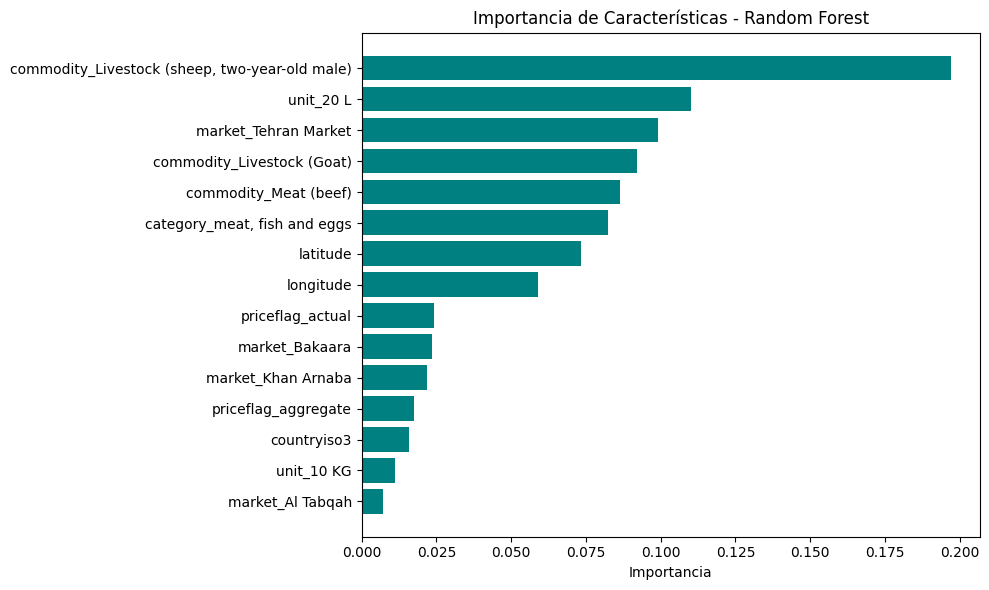

In [13]:
importances = model_rf.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Importancia")
plt.title("Importancia de Características - Random Forest")
plt.tight_layout()
plt.savefig("food_crisis/graphics/random_forest/importances.png")
plt.show()

Estas son las variables con más importancia: 

- commodity_Livestock (sheep, two-year-old male) > Producto oveja macho de 2 años de edad
- unit_20 L
- market_Tehran Market
- commodity_Livestock (Goat)
- commodity_Meat (beef)
- category_meat, fish and eggs


Esto significa que el tipo de producto (commodity) sobre todo carnes y ganado tiene el mayor impacto en el precio. 
La unidad de medida como "20 L" influye mucho seguramente en productos líquidos que suelen comportarse de forma similar en cuanto a precio.

El mercado específico (Tehran Market) es relevante ya que en esa región los precios se ven afectados de forma importante. 


También hay variables con una importancia media como son: "latitude", "longitude", y "priceflag_actual", que aportan valor. La ubicación geográfica influye de forma moderada en el precio del producto, y el tipo de precio también aunque con diferencias entre los precios agregados y los reales.

Las variables con menor importancia puede deberse a que no tienen mucha variabilidad o no están bien representadas o simplementa no aportan valor de predicción al precio. 

### Predicción vs Valor Real

Permite ver visualmente si el modelo hace buenas predicciones. Esto se puede ver que se cumple, ya que los puntos se alinean bastante en la diagonal que sería predicción = valor real. 

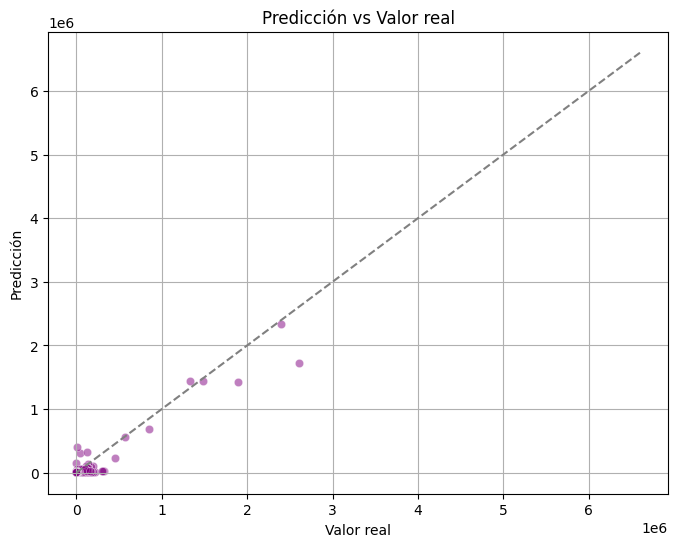

In [14]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5, color='purple')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicción vs Valor real")
plt.grid(True)
plt.savefig("food_crisis/graphics/random_forest/predictions.png")
plt.show()

### Distribución del error o residuos

Se suele representar para ver la distribución de residuos, se calcula la diferencia entre las predicciones y llos valores reales:

> residuo = real - predicho

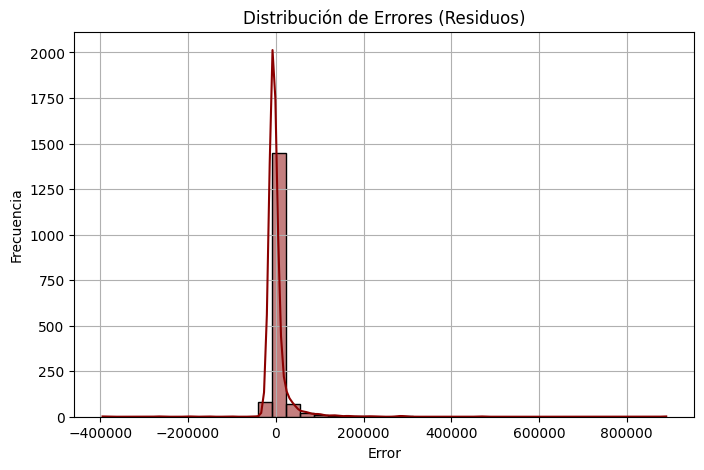

In [15]:
residuals = y_test - y_pred_rf
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=40, kde=True, color='darkred')
plt.title("Distribución de Errores (Residuos)")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.savefig("food_crisis/graphics/random_forest/error_distribution.png")
plt.show()

La campana es simétrica y se puede ver que está centrada en el cero  y es simétrica sin muchas colas, por lo que tiene errores bajos y bien distribuidos. Esto indica un modelo bien ajustado, y descarta la presencia de sesgo y por tanto las variables importantes están siendo consideradas. 

 ### Curva de aprendizaje (Learning Curve)

La curva de aprendizaje evalua el modelo a medida que aumenta el conjunto de entrenamiento. 

Se usa para ver si el modelo necesita más datos para mejorar su aprendizaje, o si está sobreajustado (overfitting) o subajustado (underfitting).

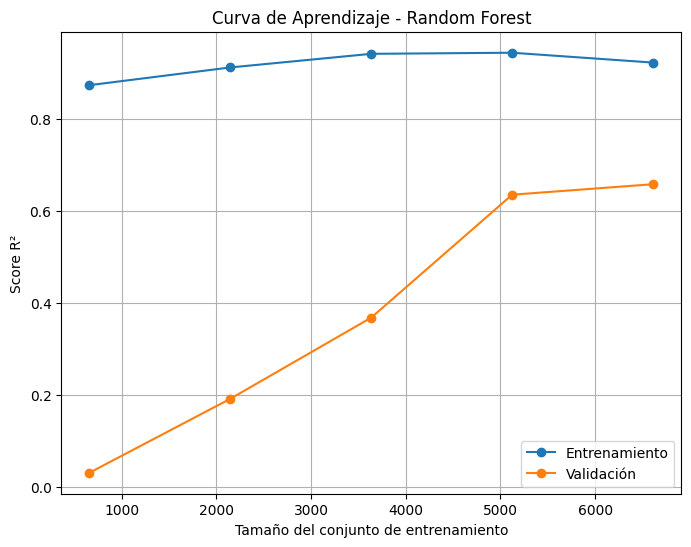

In [17]:
train_sizes, train_scores, test_scores = learning_curve(
    model_rf, X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Entrenamiento")
plt.plot(train_sizes, test_mean, 'o-', label="Validación")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Score R²")
plt.title("Curva de Aprendizaje - Random Forest")
plt.legend()
plt.grid(True)
plt.savefig("food_crisis/graphics/random_forest/learning_curve.png")
plt.show()

Se puede ver que la validación no tiene valores de score  tan altos como el entrenamiento, sobre todo con tamaños pequeños del conjunto de entrenamiento, y a medida que aumenta ese tamaño, aumenta la puntuación por lo que se puede decir que con un tamaño de 5000 los valores indican un modelo balanceado y bien entrenado. 

### Métricas de Evaluación del modelo

* R^2 o Coeficiente de Determinación
Mide cómo de bien se ajustaron las predicciones a los datos reales. Un valor cercano a 1 indica buena capacidad de predicción.

* Error Cuadrático Medio (MSE)
Mide la diferencia promedio entre las predicciones del modelo y los valores reales. Un MSE bajoj indica un mejor rendimiento del modelo. 

* RMSE: Raíz del MSE 

* MAE: Error Absoluto Promedio 
El valor del MAE indica las unidades de la variable objetivo en las que se equivoca el modelo.

In [18]:
# Evaluación para el modelo de Random Forest
print('R^2 Random Forest:', r2_score(y_test, y_pred_rf))
print('MSE Random Forest:', mean_squared_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))

R^2 Random Forest: 0.8971436202589393
MSE Random Forest: 1383756986.6481476
RMSE: 37198.88421240814
MAE: 12799.665432561318


La medida R^2 es un valor alto por lo que el modelo captura correctamente la variabilidad de los precios. 

La medida MSE tiene un valor alto, aunque no es fácil de interpretar directamente ya que está en unidades cuadradas del precio. Aun así, refleja que existen grandes errores en algunas predicciones.

La medida RMSE es de 37.198,88 por lo que de promedio, las predicciones del modelo se desvían 37.198,88 unidades monetarias del precio real. Se puede considerar elevado, dependiendo del rango de precios en el dataset.

La medida MAE indica que de promedio, el error real por predicción es de 12.799,66 unidades de precio. Este valor no está tan afectado por valores atípicos por lo que la visión que ofrece es más estable respecto al rendimiento.


En general, el modelo tiene buen ajuste, aunque las métricas muestran que las predicciones tienen una desviación considerable. El modelo podría mejorarse con una mejor selección de variables, tratando outliers o transformando el objetivo. 